## POTATO DISEASE PREDICTION

The main aim is to predict if the input image of a potato leaf is a healty one or suffers from early blight or late blight disease. The dataset contains 1000 images each of early blight and late blight and 152 images of healthy leaf. 

Project reference - [Codebasics](https://www.youtube.com/watch?v=dGtDTjYs3xc&list=PLeo1K3hjS3utJFNGyBpIvjWgSDY0eOE8S)

In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import random
import numpy as np

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"data",
shuffle = True,
image_size=(256,256),
batch_size=32
)

Found 2152 files belonging to 3 classes.


Batches of 32 images are created. 
There are total 2152 images.

In [25]:
print("Total batches: ",int(2156/32))

Total batches:  67


**VISUALIZING IMAGES**

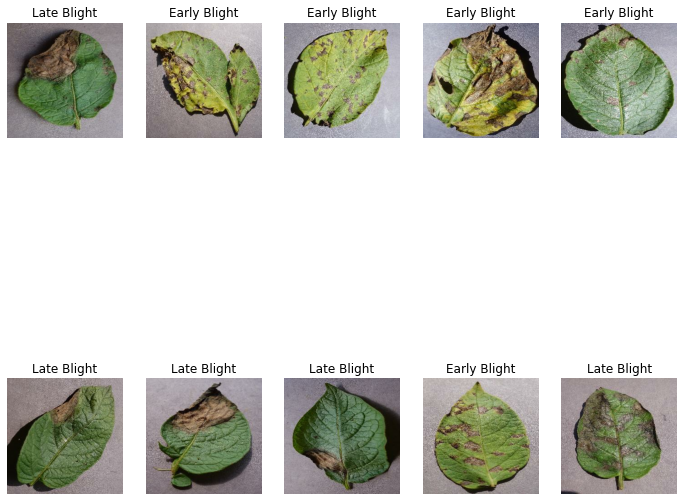

In [26]:
#Plotting 10 images from the 1st batch
plt.figure(figsize=(12,12))

for img,label in dataset.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(dataset.class_names[label[i]])

**TRAIN TEST SPLIT**

* 80% for training
* 10% for testing
* 10% for validation

In [27]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1

In [28]:
train_ds = dataset.take(int(TRAIN_SIZE*len(dataset)))

In [29]:
print('Number of batches for training: ',len(train_ds))

Number of batches for training:  54


In [30]:
test_ds = dataset.skip(int(TRAIN_SIZE*len(dataset)))
print('Remaining batches for testing and validation: ',len(test_ds))

Remaining batches for testing and validation:  14


In [31]:
validation_ds = test_ds.take(int(VALIDATION_SIZE*len(dataset)))
print('Number of batches for validation: ',len(validation_ds))

Number of batches for validation:  6


In [32]:
test_ds = test_ds.skip(int(VALIDATION_SIZE*len(dataset)))
print('Remaining batches for testing: ',len(test_ds))

Remaining batches for testing:  8


In [33]:
#Function for the above splitting process

def splitDataset(data, train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True, shuffle_size=1000):
    data_size = len(data)
    
    #Shuffling the dataset
    if shuffle:
        data = data.shuffle(buffer_size=shuffle_size,seed=12)
        
        
    train_size = int(train_split*data_size)
    val_size = int(val_split*data_size)
    
    #Get train data
    train = data.take(train_size)
    
    #Get val data
    val = data.skip(train_size).take(val_size)
    
    #Get test data
    test = data.skip(train_size).skip(val_size)
    
    return train, val, test

In [34]:
train_ds, val_ds, test_ds = splitDataset(dataset)

In [35]:
print('Train data: {}'.format(len(train_ds)))
print('Test data: {}'.format(len(test_ds)))
print('Validation data: {}'.format(len(val_ds)))

Train data: 54
Test data: 8
Validation data: 6


In [36]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [37]:
for i in train_ds.take(1):
    print(i[0])

tf.Tensor(
[[[[184. 177. 184.]
   [184. 177. 184.]
   [184. 177. 184.]
   ...
   [152. 140. 144.]
   [160. 148. 152.]
   [125. 113. 117.]]

  [[188. 181. 188.]
   [187. 180. 187.]
   [187. 180. 187.]
   ...
   [128. 116. 120.]
   [114. 102. 106.]
   [134. 122. 126.]]

  [[189. 182. 189.]
   [188. 181. 188.]
   [187. 180. 187.]
   ...
   [152. 140. 144.]
   [120. 108. 112.]
   [150. 138. 142.]]

  ...

  [[192. 183. 186.]
   [193. 184. 187.]
   [193. 184. 187.]
   ...
   [157. 142. 147.]
   [133. 118. 123.]
   [144. 129. 134.]]

  [[194. 185. 188.]
   [194. 185. 188.]
   [193. 184. 187.]
   ...
   [130. 115. 120.]
   [143. 128. 133.]
   [150. 135. 140.]]

  [[196. 187. 190.]
   [195. 186. 189.]
   [194. 185. 188.]
   ...
   [165. 150. 155.]
   [150. 135. 140.]
   [152. 137. 142.]]]


 [[[147. 137. 148.]
   [179. 169. 180.]
   [153. 143. 154.]
   ...
   [174. 162. 172.]
   [145. 133. 143.]
   [198. 186. 196.]]

  [[140. 130. 141.]
   [161. 151. 162.]
   [164. 154. 165.]
   ...
   [157. 1

**The image pixels are in the range 0 to 255. We'll rescale it between 0 and 1 for faster and better calculation.**

In [38]:
#Rescaling and resizing the images

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(scale=1./255)
])

In [39]:
#Data augmentation to create additional images - flipping and rotation

augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

**MODELLING**

In [40]:
model1 = models.Sequential([
    resize_and_rescale,
    augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (32,256, 256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model1.build(input_shape=(32,256,256,3))

In [41]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 60, 60, 64)         

In [42]:
model1.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [43]:
model1_history = model1.fit(
train_ds,
epochs=50,
batch_size=32,
verbose=1,
validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 59s 1s/step - loss: 0.8560 - accuracy: 0.5581 - val_loss: 0.6929 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 58s 1s/step - loss: 0.5415 - accuracy: 0.7737 - val_loss: 0.3777 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 56s 1s/step - loss: 0.3804 - accuracy: 0.8521 - val_loss: 0.4130 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 56s 1s/step - loss: 0.2549 - accuracy: 0.9020 - val_loss: 0.2504 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 56s 1s/step - loss: 0.2139 - accuracy: 0.9143 - val_loss: 0.2891 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 56s 1s/step - loss: 0.1986 - accuracy: 0.9302 - val_loss: 0.1448 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 57s 1s/step - loss: 0.2085 - accuracy: 0.9225 - val_loss: 0.1802 - val_accuracy: 0.9375
Epoch 8/50
54/54 [==

In [44]:
model1.evaluate(test_ds)

8/8 [==============================] - 3s 244ms/step - loss: 0.0139 - accuracy: 0.9961


[0.013852282427251339, 0.99609375]

Accuracy on test dataset - ~99%

**Let's add one more layer and retrain.**

In [45]:
model2 = models.Sequential([
    resize_and_rescale,
    augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (32,256, 256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model2.build(input_shape=(32,256,256,3))

In [46]:
model2.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [47]:
model2_history = model2.fit(
train_ds,
epochs=50,
batch_size=32,
verbose=1,
validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 72s 1s/step - loss: 0.8967 - accuracy: 0.4783 - val_loss: 0.7828 - val_accuracy: 0.6131
Epoch 2/50
54/54 [==============================] - 139s 3s/step - loss: 0.6513 - accuracy: 0.6925 - val_loss: 0.4015 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 129s 2s/step - loss: 0.4161 - accuracy: 0.8241 - val_loss: 0.3436 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 60s 1s/step - loss: 0.2896 - accuracy: 0.8815 - val_loss: 0.1864 - val_accuracy: 0.9286
Epoch 5/50
54/54 [==============================] - 60s 1s/step - loss: 0.2267 - accuracy: 0.9120 - val_loss: 0.2520 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 61s 1s/step - loss: 0.2257 - accuracy: 0.9161 - val_loss: 0.1859 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.2022 - accuracy: 0.9261 - val_loss: 0.2423 - val_accuracy: 0.9115
Epoch 8/50
54/54 [

In [48]:
model2.evaluate(test_ds)

8/8 [==============================] - 3s 204ms/step - loss: 0.0125 - accuracy: 0.9961


[0.012547713704407215, 0.99609375]

Model 2 has 99% accuracy on test data

Adding extra layer does not help here.

In [49]:
model1_history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [50]:
model1_history.history

{'loss': [0.8559912443161011,
  0.5415356159210205,
  0.3804120421409607,
  0.2549208402633667,
  0.21392402052879333,
  0.19858518242835999,
  0.20846016705036163,
  0.1518651694059372,
  0.1558864861726761,
  0.1363988220691681,
  0.1329493224620819,
  0.15134724974632263,
  0.11986764520406723,
  0.11549008637666702,
  0.10372193902730942,
  0.1299799382686615,
  0.08763231337070465,
  0.1149766594171524,
  0.0913097932934761,
  0.058052971959114075,
  0.14984701573848724,
  0.09484896063804626,
  0.09003792703151703,
  0.07246042042970657,
  0.0774463340640068,
  0.05078040435910225,
  0.050844088196754456,
  0.04334783926606178,
  0.03217368945479393,
  0.054475873708724976,
  0.03661920502781868,
  0.026926858350634575,
  0.08303017169237137,
  0.049078524112701416,
  0.06474054604768753,
  0.06237538531422615,
  0.04124768078327179,
  0.02210920676589012,
  0.021984700113534927,
  0.025409186258912086,
  0.06979355961084366,
  0.03394071385264397,
  0.04727167636156082,
  0.0200

The history callback has the loss, accuracy, validation_loss, validation_accuracy stored.

**MODEL 1**

In [51]:
acc = model1_history.history['accuracy']
loss = model1_history.history['loss']
val_acc = model1_history.history['val_accuracy']
val_loss = model1_history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation Loss - Model 1')

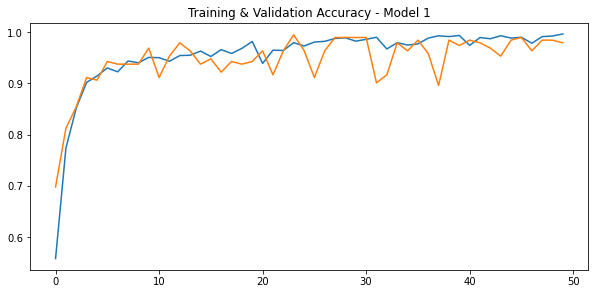

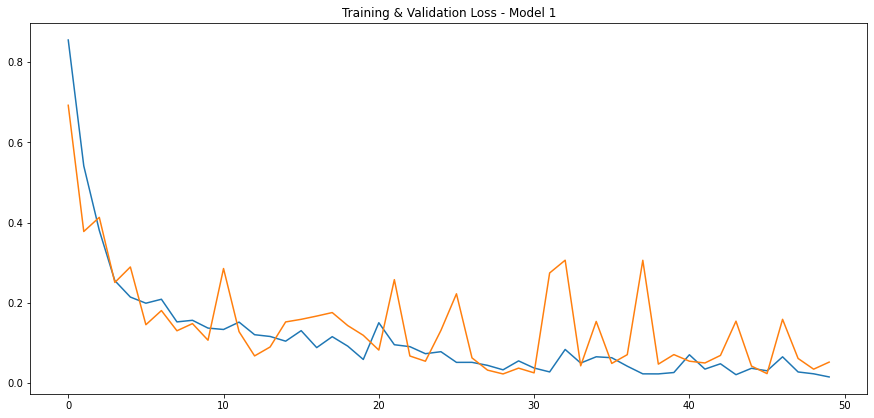

In [52]:
#Plotting the above parameters

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(range(model1_history.params['epochs']), acc, label='Training Accuracy')
plt.plot(range(model1_history.params['epochs']), val_acc, label='Validation Accuracy')
plt.title("Training & Validation Accuracy - Model 1")


#Plotting the above parameters

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
plt.plot(range(model1_history.params['epochs']), loss, label='Training Loss')
plt.plot(range(model1_history.params['epochs']), val_loss, label='Validation Loss')
plt.title("Training & Validation Loss - Model 1")

**MODEL 2**

Text(0.5, 1.0, 'Training & validation Loss - Model 2')

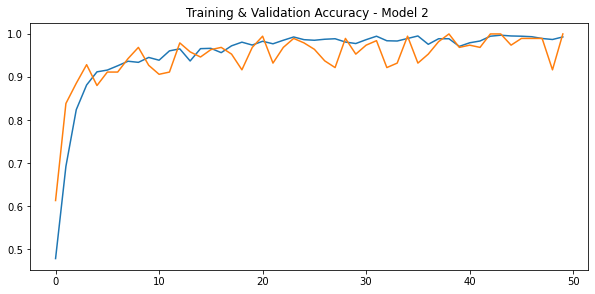

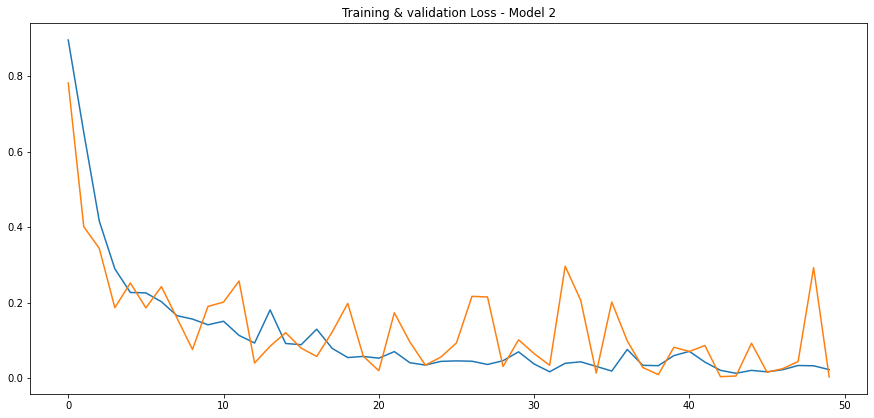

In [53]:
acc = model2_history.history['accuracy']
loss = model2_history.history['loss']
val_acc = model2_history.history['val_accuracy']
val_loss = model2_history.history['val_loss']
                                  
#Plotting the above parameters

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(range(model2_history.params['epochs']), acc, label='Training Accuracy')
plt.plot(range(model2_history.params['epochs']), val_acc, label='Validation Accuracy')
plt.title("Training & Validation Accuracy - Model 2 ")


#Plotting the above parameters

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
plt.plot(range(model2_history.params['epochs']), loss, label='Training Loss')
plt.plot(range(model2_history.params['epochs']), val_loss, label='Validation Loss')
plt.title("Training & validation Loss - Model 2")

**PREDICTION ON  RANDOM BATCH USING MODEL2**

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    prediction = model.predict(img_array)
    predicted_cls = dataset.class_names[np.argmax(prediction[0])]
    confidence = round(100* (np.max(prediction[0])),2)
    
    return predicted_cls, confidence


<ipython-input-55-8485edd82567>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(8,4,i+1)


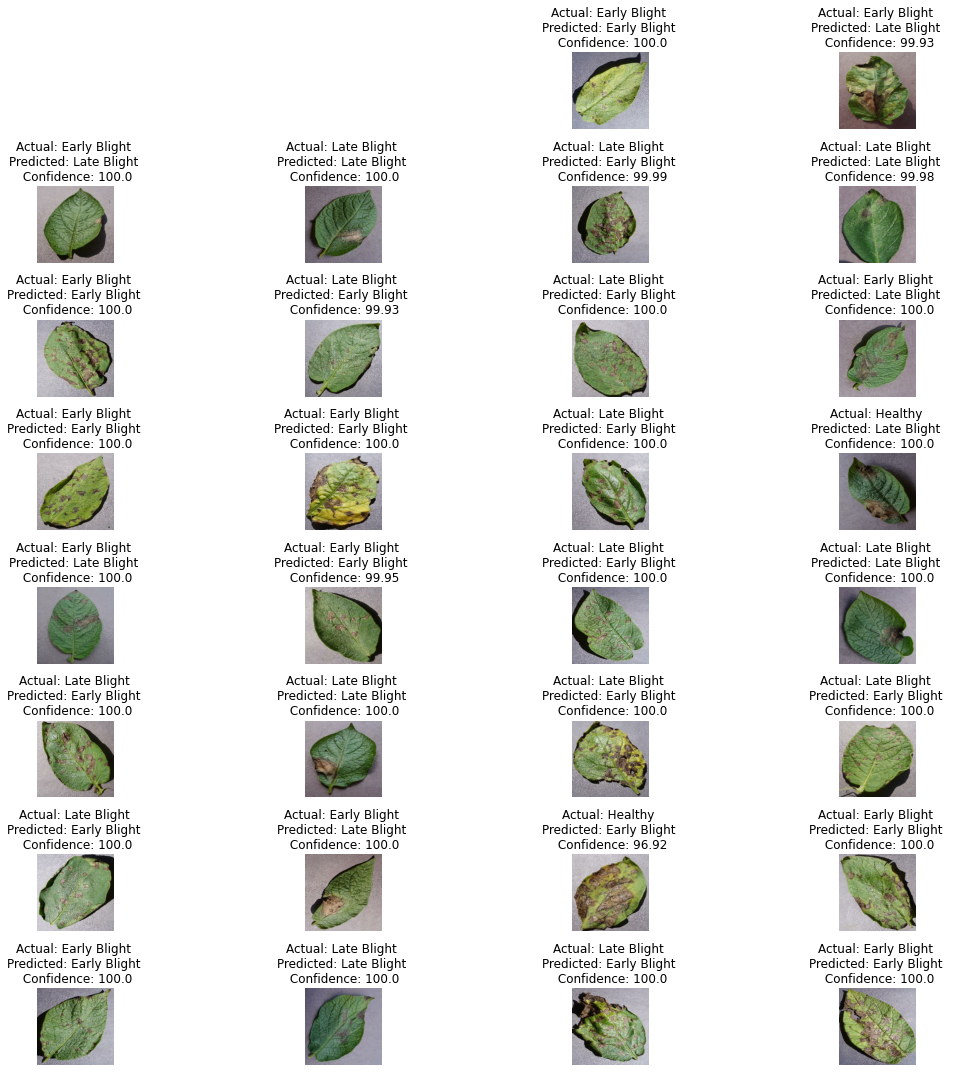

In [55]:
plt.figure(figsize=(15,15))

random_batch = random.choice(range(0,len(test_ds)))
#print('Total images for testing: {}'.format(len(img_batch)))

for img_batch, label_batch in test_ds.take(random_batch):
    for i in range(0,len(img_batch)):
        ax = plt.subplot(8,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        actual_cls = dataset.class_names[label[i]]
        predicted_cls, confidence = predict(model2, img_batch[i])
        plt.tight_layout()
        plt.title('Actual: {} \nPredicted: {} \n Confidence: {}'.format(actual_cls, predicted_cls, confidence))

In [56]:
model1.save('models/model1')

INFO:tensorflow:Assets written to: models/model1/assets


In [57]:
model2.save('models/model2')

INFO:tensorflow:Assets written to: models/model2/assets


In [58]:
dataset.class_names

['Early Blight', 'Healthy', 'Late Blight']